# Подготовка датасета

In [1]:
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np


def add_next_part(df, next_part):
    return pd.concat([df, next_part], ignore_index=True)

def replace_commas_and_convert_to_float(value):
    return float(value.replace(',', '.'))

feature = 'Отделка'
train_ratio = 0.8

flats_df = pd.read_excel('../cian_spb.xlsx')
flats_df = flats_df.loc[:, [feature, "Общая площадь", "Жилая площадь", "Площадь кухни", "Стоимость"]]
flats_df.dropna(inplace=True)
numeric_columns = ["Общая площадь", "Жилая площадь", "Площадь кухни"]
flats_df[numeric_columns] = flats_df[numeric_columns].map(replace_commas_and_convert_to_float)
flats_df = flats_df.sample(frac=1)
df = flats_df

In [2]:
def transform_labels(y):
    return np.where(y == 'Без отделки', 1, -1)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=[feature]))
y = transform_labels(df[feature])


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio)

In [4]:
y_test

array([-1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1, -1,
       -1,  1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  1, -1,  1, -1,  1, -1,  1, -1, -1,  1, -1, -1,  1,
        1, -1, -1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1,  1, -1, -1, -1,  1, -1,  1, -1,  1,  1,  1, -1,  1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1, -1,
       -1,  1, -1,  1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1])

# Поиск лучших гиперпараметров

In [5]:
import optuna
from sklearn.metrics import f1_score

train_size = int(X_train.shape[0] * train_ratio)
train_data = X_train[: train_size]
valid_data = X_train[train_size:]
train_target = y_train[: train_size]
valid_target = y_train[train_size :]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Для классификатора методом градиентного спуска

In [6]:
from linear import GDClassifier

def gd_objective(trial):
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    epochs = trial.suggest_int('epochs', 10, 100)
    loss = trial.suggest_categorical('loss', ['linear', 'logarithmic', 'square', 'sigmoid'])
    l1 = trial.suggest_float('l1', 1e-2, 1, log=True)
    l2 = trial.suggest_float('l2', 1e-2, 1, log=True)
    classifier = GDClassifier(lr, epochs, loss, l1, l2)
    classifier.fit(train_data, train_target)
    return f1_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(gd_objective, n_trials=100)
print(study.best_params)

[I 2024-10-21 16:12:14,251] A new study created in memory with name: no-name-5d5fb489-cf31-4a16-8bc2-2c6e5046c360
[I 2024-10-21 16:12:14,338] Trial 0 finished with value: 0.38235294117647056 and parameters: {'lr': 1.7541398602282561e-06, 'epochs': 88, 'loss': 'sigmoid', 'l1': 0.44083579960682207, 'l2': 0.19198816941232574}. Best is trial 0 with value: 0.38235294117647056.
[I 2024-10-21 16:12:14,377] Trial 1 finished with value: 0.38235294117647056 and parameters: {'lr': 9.584363776423332e-06, 'epochs': 28, 'loss': 'sigmoid', 'l1': 0.05037008200838757, 'l2': 0.02894281479757835}. Best is trial 0 with value: 0.38235294117647056.
[I 2024-10-21 16:12:14,402] Trial 2 finished with value: 0.38235294117647056 and parameters: {'lr': 5.0731384626984275e-06, 'epochs': 18, 'loss': 'sigmoid', 'l1': 0.013936074856028822, 'l2': 0.6612364605889993}. Best is trial 0 with value: 0.38235294117647056.
[I 2024-10-21 16:12:14,424] Trial 3 finished with value: 0.37681159420289856 and parameters: {'lr': 8.11

{'lr': 4.1931108102870984e-05, 'epochs': 48, 'loss': 'square', 'l1': 0.010979317761951773, 'l2': 0.025060515374317388}


# Для классификатора методом опорных векторов

In [7]:
from linear import SVMClassifier

def svm_objective(trial):
    c = trial.suggest_float('C', 1e-2, 1e2, log=True)
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    epochs = trial.suggest_int('epochs', 10, 100)
    kernel = trial.suggest_categorical('kernel', ['linear', 'polynomial', 'gaussian', 'laplacian'])
    r, n, sigma, alpha = 0, 2, 1, 1
    if kernel == 'polynomial':
        r = trial.suggest_float('r', 0, 1)
        n = trial.suggest_int('n', 1, 2)
    if kernel == 'gaussian':
        sigma = trial.suggest_float('sigma', 1e-1, 10, log=True)
    if kernel == 'laplacian':
        alpha = trial.suggest_float('alpha', 1e-1, 10, log=True)
    classifier = SVMClassifier(c, lr, epochs, kernel, r, n, sigma, alpha)
    classifier.fit(train_data, train_target)
    return f1_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(svm_objective, n_trials=100)
print(study.best_params)

[I 2024-10-21 16:12:20,938] A new study created in memory with name: no-name-1a2d5ecb-bc78-4414-b820-e672352b09f5
[I 2024-10-21 16:12:21,156] Trial 0 finished with value: 0.3790849673202614 and parameters: {'C': 5.2285208871537705, 'lr': 1.1768710858995873e-06, 'epochs': 78, 'kernel': 'laplacian', 'alpha': 2.9082588188484975}. Best is trial 0 with value: 0.3790849673202614.
[I 2024-10-21 16:12:21,197] Trial 1 finished with value: 0.4507042253521127 and parameters: {'C': 0.03678355796249893, 'lr': 0.00019479488883854447, 'epochs': 38, 'kernel': 'linear'}. Best is trial 1 with value: 0.4507042253521127.
[I 2024-10-21 16:12:21,212] Trial 2 finished with value: 0.4507042253521127 and parameters: {'C': 0.05041820561543984, 'lr': 0.000675563363097661, 'epochs': 13, 'kernel': 'linear'}. Best is trial 1 with value: 0.4507042253521127.
[I 2024-10-21 16:12:21,267] Trial 3 finished with value: 0.37681159420289856 and parameters: {'C': 0.015199089007329719, 'lr': 0.009115721194656302, 'epochs': 85

{'C': 7.580914677480439, 'lr': 0.004075908474344796, 'epochs': 89, 'kernel': 'linear'}


# Кривые обучения

In [25]:
from linear import GDClassifier, SVMClassifier, MatrixClassifier
from sklearn.metrics import f1_score

In [26]:
gd_classifier = GDClassifier(lr=4.1931108102870984e-05, epochs=100, loss='square', l1=0.010979317761951773, l2=0.025060515374317388)
gd_classifier.debug_fit(X_train, y_train, X_test, y_test)

In [27]:
svm_classifier = SVMClassifier(c=7.580914677480439, lr=0.004075908474344796, epochs=100, kernel='linear')
svm_classifier.debug_fit(X_train, y_train, X_test, y_test)

In [28]:
matrix_classifier = MatrixClassifier()
matrix_classifier.fit(X_train, y_train, 0.011)
matrix_test = np.full(100, f1_score(y_test, matrix_classifier.predict(X_test)))

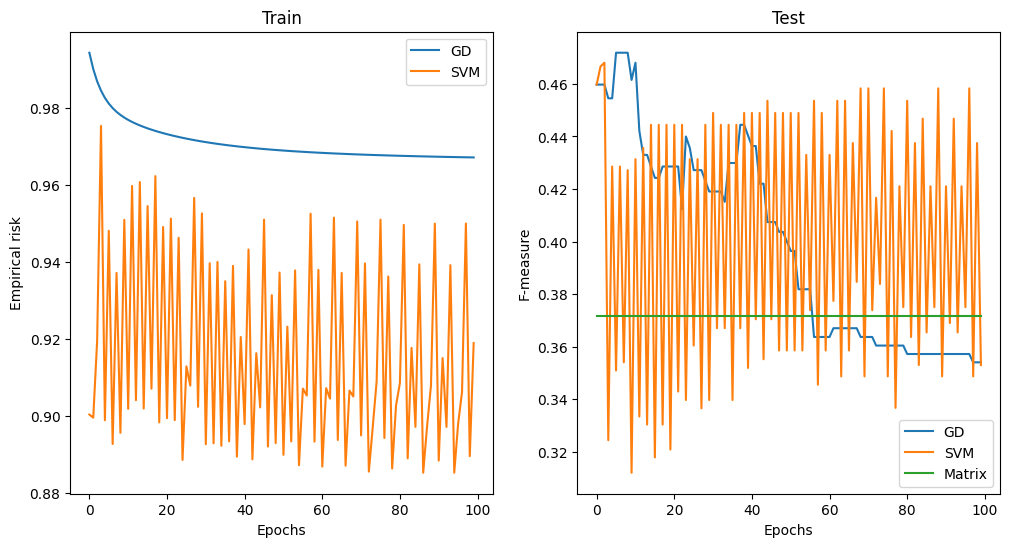

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Train')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Empirical risk')
ax[0].plot(gd_classifier.train_history, label='GD')
ax[0].plot(svm_classifier.train_history, label='SVM')
ax[0].legend()

ax[1].set_title('Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('F-measure')
ax[1].plot(gd_classifier.test_history, label='GD')
ax[1].plot(svm_classifier.test_history, label='SVM')
ax[1].plot(matrix_test, label='Matrix')
ax[1].legend()

# Библиотечные реализации

## Подбор гиперпараметров

In [41]:
from sklearn.linear_model import ElasticNet

def en_objective(trial):
    alpha = trial.suggest_float('alpha', 1e-2, 1, log=True)
    l1 = trial.suggest_float('l1', 1e-2, 1, log=True)
    classifier = ElasticNet(alpha=alpha, l1_ratio=l1)
    classifier.fit(train_data, train_target)
    prediction = classifier.predict(valid_data)
    return f1_score(valid_target, np.array([1 if prediction[i] >= 0 else -1 for i in range(len(prediction))]))

study = optuna.create_study(direction='maximize')
study.optimize(en_objective, n_trials=100)
print(study.best_params)

[I 2024-10-21 16:19:26,558] A new study created in memory with name: no-name-550d69b0-3445-4e2c-af83-c206393380f3
[I 2024-10-21 16:19:26,564] Trial 0 finished with value: 0.0625 and parameters: {'alpha': 0.010874271427619594, 'l1': 0.26496158040546247}. Best is trial 0 with value: 0.0625.
[I 2024-10-21 16:19:26,567] Trial 1 finished with value: 0.0625 and parameters: {'alpha': 0.04279899140251726, 'l1': 0.01657131168082832}. Best is trial 0 with value: 0.0625.
[I 2024-10-21 16:19:26,571] Trial 2 finished with value: 0.06451612903225806 and parameters: {'alpha': 0.02623957600840664, 'l1': 0.20250251125279323}. Best is trial 2 with value: 0.06451612903225806.
[I 2024-10-21 16:19:26,575] Trial 3 finished with value: 0.0 and parameters: {'alpha': 0.13528102396073588, 'l1': 0.4884855157428755}. Best is trial 2 with value: 0.06451612903225806.
[I 2024-10-21 16:19:26,577] Trial 4 finished with value: 0.0 and parameters: {'alpha': 0.28439632237181617, 'l1': 0.6671204083569893}. Best is trial 2

{'alpha': 0.07654531516639558, 'l1': 0.44055522815571035}


In [14]:
from sklearn.svm import SVC

def svc_objective(trial):
    c = trial.suggest_float('C', 1e-2, 1e2, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree, coef0 = 1, 0
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 1, 3)
        coef0 = trial.suggest_float('coef0', 0, 2)
    if kernel == 'sigmoid':
        coef0 = trial.suggest_float('coef0', 0, 2)
    classifier = SVC(C=c, kernel=kernel, degree=degree, coef0=coef0)
    classifier.fit(train_data, train_target)
    return f1_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(svc_objective, n_trials=100)
print(study.best_params)

[I 2024-10-21 16:12:30,439] A new study created in memory with name: no-name-9ff6b444-d3ed-43ac-9264-398d16ee065f
[I 2024-10-21 16:12:30,447] Trial 0 finished with value: 0.0 and parameters: {'C': 0.43794603926417064, 'kernel': 'rbf'}. Best is trial 0 with value: 0.0.
[I 2024-10-21 16:12:30,482] Trial 1 finished with value: 0.0 and parameters: {'C': 9.46414280183781, 'kernel': 'poly', 'degree': 2, 'coef0': 1.325870172083889}. Best is trial 0 with value: 0.0.
[I 2024-10-21 16:12:30,488] Trial 2 finished with value: 0.06666666666666667 and parameters: {'C': 0.827978848462232, 'kernel': 'poly', 'degree': 3, 'coef0': 1.0449235681516262}. Best is trial 2 with value: 0.06666666666666667.
[I 2024-10-21 16:12:30,495] Trial 3 finished with value: 0.15789473684210525 and parameters: {'C': 47.26871911249441, 'kernel': 'rbf'}. Best is trial 3 with value: 0.15789473684210525.
[I 2024-10-21 16:12:30,498] Trial 4 finished with value: 0.15625 and parameters: {'C': 4.3175541831403175, 'kernel': 'sigmoi

{'C': 3.531519988306766, 'kernel': 'sigmoid', 'coef0': 0.783627989256396}


## Кривые обучения

In [42]:
en_classifier = ElasticNet(alpha=0.07654531516639558, l1_ratio=0.44055522815571035)
en_classifier.fit(X_train, y_train)
prediction = en_classifier.predict(X_test)
en_result = f1_score(y_test, np.array([1 if prediction[i] >= 0 else -1 for i in range(len(prediction))]))

In [43]:
svc_classifier = SVC(C=3.531519988306766, kernel='sigmoid', coef0=0.783627989256396)
svc_classifier.fit(X_train, y_train)
svc_result = f1_score(y_test, svc_classifier.predict(X_test))

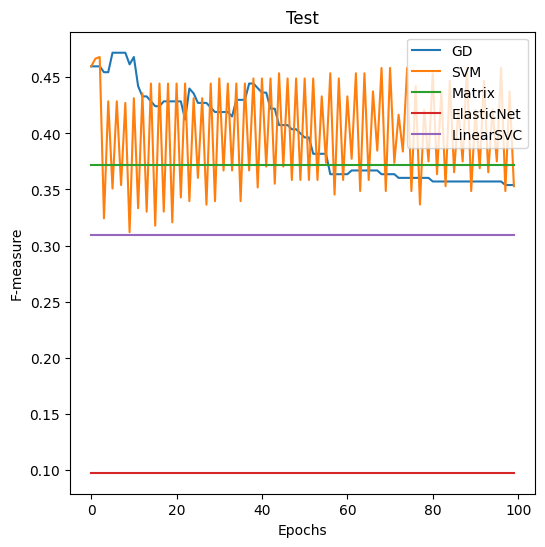

In [44]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_title('Test')
ax.set_xlabel('Epochs')
ax.set_ylabel('F-measure')
ax.plot(gd_classifier.test_history, label='GD')
ax.plot(svm_classifier.test_history, label='SVM')
ax.plot(matrix_test, label='Matrix')
ax.plot(np.full(100, en_result), label='ElasticNet')
ax.plot(np.full(100, svc_result), label='LinearSVC')
ax.legend()

# Сравнение коэффициентов

## My Gradient Descent & sklearn ElasticNet

In [45]:
from sklearn.metrics import mean_squared_error

gd_factors = pd.Series(gd_classifier.w, name='GD')
en_factors = pd.Series(en_classifier.sparse_coef_.toarray().flatten(), name='ElasticNet')
print(pd.DataFrame([gd_factors, en_factors]).transpose())
print('MSE: ', mean_squared_error(gd_classifier.w, en_classifier.sparse_coef_.toarray().flatten()))

         GD  ElasticNet
0  0.036581    0.000000
1 -0.078635    0.000000
2  0.145805    0.121248
3  0.075478    0.020752
MSE:  0.0027799077569283038


## My SVM & sklearn SVC 

In [46]:
svc_classifier.support_vectors_

array([[-3.57221843e-01, -5.77464394e-01,  3.17363335e-01,
        -2.12980442e-01],
       [ 4.15500739e-02,  8.97789247e-02,  3.73009417e-01,
        -3.84839813e-01],
       [ 3.28149459e-01,  3.81347434e-01,  8.04266550e-01,
         5.91372875e-03],
       [ 2.46386871e-01, -7.28265899e-02,  1.31899281e+00,
         3.37061321e-01],
       [ 7.71388747e-01,  1.00934115e+00,  6.69559672e-02,
         1.44193218e-01],
       [-1.29434144e-01, -5.60643134e-01,  6.69559672e-02,
         2.41960223e-01],
       [-2.06893437e-01, -4.65322660e-01,  5.26036142e-01,
        -8.11794888e-03],
       [ 6.27796580e-02,  7.85647513e-02,  4.84301580e-01,
         1.43551299e-02],
       [-1.11647195e-01,  1.79492312e-01, -4.06035728e-01,
        -3.84385467e-01],
       [-1.92549123e-01, -1.90575411e-01,  2.52214059e-02,
        -3.89515785e-01],
       [-4.70977838e-02,  5.61364045e-02,  4.00832458e-01,
        -3.82225037e-01],
       [ 1.85853868e-01,  3.92561607e-01,  1.92159651e-01,
      

In [47]:
support_vectors = []
for i in range(X_train.shape[0]):
    m = np.dot(X_train[i], svm_classifier.w) * y_train[i]
    if 0.9 <= m <= 1.1:
        support_vectors.append(X_train[i])
np.asarray(support_vectors)

array([[ 0.89474984,  0.54956003,  1.93109971,  0.9865993 ],
       [-0.28722159,  0.2692057 , -1.28246152, -0.40488766],
       [-0.2327132 ,  0.37574035, -1.28246152, -0.37945064],
       [ 1.87016316,  1.19437501,  0.87382415,  1.15080506],
       [ 0.31237071,  1.03737658, -1.07378871,  0.03939556],
       [ 0.07999283, -0.16253998,  0.19215965,  0.91700953]])